# Introduction: Prediction Engineering - Labeling

In this notebook, we will develop a method for labeling customer data for a prediction problem. The objective of labeling is to create a set of historical examples of what we want to predict based on the business need: in this problem, our goal is to predict customer churn, so we want to label examples of churned customers using past data.

The end outcome of this notebook is a set of labels along with cutoff times (in a table called a label times table) that can be used in Featuretools for automated feature engineering. These features in turn will be used to train a predictive model to forecast customer churn, a common need for subscription-based business models, and one for which machine learning is well-suited.

## Definition of Churn

The [data (publicly available)](https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data) consists of customer transaction records showing membership to KKBOX, a music streaming service. The definition of churn is __a customer going without an active membership for a certain number of days.__ The number of days and when to make predictions are left as parameters that can be adjusted based on the particular business need. For example, we can say that churn is no active membership for 30 days and make predictions on the first of each month or 14 days and make predictions on the first and the fifteenth of the month. 

### Dataset

For each customer, we have background information (in `members`), logs of listening behavior (in `logs`), and transactions information (in `trans`). The only data we need for labeling is the transactions information.

The transactions data consists of a number of variables, the most important of which are customer id (`msno`), the date of transaction (`transaction_date`), and the expiration date of the membership (`membership_expire_date`). Using these columns, we can find each churn for each customer and the corresponding date on which it occurred. Let's look at a few typical examples of customer transaction data to illustrate how to find a churn example. For these examples, we will set the definition of churn as 30 days without an active membership.

__Example 1:__

```
(transaction_date, membership_expire_date, is_cancel)

(2017-01-01, 2017-02-28, false)

(2017-02-25, 0217-03-15, false)

(2017-04-30, 3017-05-20, false)
```
This customer is a churn because they go without a membership for over 30 days, from 03-15 to 04-30. 

__Example 2:__
```
(transaction_date, membership_expire_date, is_cancel)

(2017-01-01, 2017-02-28, false)

(2017-02-25, 2017-04-03, false)

(2017-03-15, 2017-03-16, true)

(2017-04-01, 3017-06-30, false)
```

This customer is not a churn. Even though they have a cancelled membership (cancelled on 03-15 and takes effect on 03-16), the membership plan is renewed within 30 days. 

__Example 3:__
```
(transaction_date, membership_expire_date, is_cancel)

(2017-05-30, 2017-06-30, false)

(2017-07-01, 2017-08-01, false)

(2017-08-01, 2017-09-01, false)

(2017-10-15, 2017-11-15, false)
```
This customer is a churn because they go without a membership for over 30 days, from 09-01 to 10-15. 

These three examples illustrate different situations that occur frequently in the data.

### Approach

Given the data above, to find each example of churn, we need to find the difference between one `membership_expire_date` and the next `transaction_date`. If this period is greater than the days selected for a churn, then this is a positive example of churn. For each churn, we can find the exact date on which it occurred by adding the number of days for a churn to the `membership_expire_date` associated with the churn. 

We can very rapidly label customer transactions by shifting each `transaction_date` back by one and matching it to the previous `membership_expire_date`. We then find the difference in days between these two (`transaction` - `expire`) and if the difference is greater than the number established for churn, this is a positive label. If this is not clear, we'll shortly see how to do it in code which should clear things up! 

The general framework is implemented in two functions:

1. `customer_to_label_times(customer_id, transactions, **params)`
2. `make_label_times(transactions, **params)` 

The first takes a single customer and returns a table of cutoff times along with the associated labels. The second goes through all of the customers and applies the `customer_to_label_times` function to each one. The end outcome is a single table consisting of the label times for each customer. Since we already partitioned the data, we can run this function over multiple partitions in parallel to rapidly label all the data.

## Cutoff Times

A critical part of the label times table is the cutoff time associated with each label. This time at which we make a prediction are referred to as _cutoff_ times and they represent when all our data for making features for that particular label must be before. For instance, if our cutoff time is July 1, and we want to make predictions of churn during the month of July, all of our features for this label must be made with data from before July 1. Cutoff times are a critical consideration when feature engineering in order to prevent data leakage. Later when we go to perform automated feature engineering, Featuretools will automatically filter data based on the cutoff times so we don't have to worry about invalid training data.


## Prediction Problem

Given the definition of churn and the available transactions data, there are a number of prediction problems that can be asked. A prediction problem is simply a way of framing a business need as a machine learning supervised task. For example, we can choose to make predictions of customer churn at different time points and for different time frames. In this notebook we will look at making predictions at two different points in time. 

* On the first day of every month
* On the first and fifteenth day of every month

We can also vary the number of days required for a customer to be considered a churn. We'll look at two different definitions of churn:

* No active membership for _more than_ 30 days
* No active membership for _more than_ 14 days

Another parameter in terms of a prediction problem is the format of the task. We can predict the churn itself - a __binary yes or no__ - or the __number of days__ until the customer churns - a regression problem. We could even segment the number of days until a churn into multiple groups - say 1-7 days, 8-14 days, 15-21 days and longer - and then make this a multiclass problem. 

To leave the format of the prediction problem (regression or classification) open, in this notebook, we'll find the labels - churn or not - as well as the number of days until the next churn. 

We'll look at two different business scenarios:

1. Making a prediction on the first of the month with the churn period set at 30 days.
2. Making a prediction on the first and fifteenth of the month with the churn period set at 14 days. 

Once we calculate and save these labels for the two different time frames, we can change the exact prediction problem from classification to regression. Moreover, the same features can be used for both classification and regression because they will be calculated based on the same cutoff time. This shows a few important points: for any dataset we can make multiple prediction problems based on the business requirements. We can also use the same features to make predictions for different labels if the cutoff times are the same. 

### Outcome

Our overall goal is to build two functions that will generate labels for customers. We can then run this function over our partitions in parallel (our data has been partitioned in 1000 segments, each containing a random subset of customers). Once the label dataframes with cutoff times have been created, we can use them for automated feature engineering using Featuretools.

__With all that in mind (don't worry if it hasn't sunk in yet), let's get started!__


In [1]:
import numpy as np
import pandas as pd

In [2]:
PARTITION = '100'
BASE_DIR = 's3://customer-churn-spark/'
PARTITION_DIR = BASE_DIR + 'p' + PARTITION

members = pd.read_csv(f'{PARTITION_DIR}/members.csv', 
                      parse_dates=['registration_init_time'], infer_datetime_format = True)
trans = pd.read_csv(f'{PARTITION_DIR}/transactions.csv',
                   parse_dates=['transaction_date', 'membership_expire_date'], infer_datetime_format = True)
logs = pd.read_csv(f'{PARTITION_DIR}/logs.csv', parse_dates = ['date'])

trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,G7TmHc9Gg2t8ovG/KFaB53We/0CQPELhZ5UUN2Ol3AQ=,39,30,149,149,1,2015-09-30,2015-11-13,0
1,LPbp8N7VRuqEISEVim8ppTaeYJG/rWS/t4g/dEFuWjw=,34,30,149,149,1,2016-02-29,2016-03-31,0
2,xvYqULBWzJvN8heyFtY3hbY3egyQNbXuDx0igtsoi00=,29,30,180,180,1,2017-01-31,2017-03-01,0
3,UR4iin4mAkajoa7o+AyTTmz5k3N2GR3/rZY8a4KwADI=,41,30,99,99,1,2017-01-31,2017-02-28,0
4,ax8CRhY8BMRA/ZvT1wI+2N/EdPXiSPGxa9y7bntA1Uc=,40,30,149,149,1,2016-05-04,2016-06-08,0


The transactions table is all we will need to make labels. All of our data is stored in S3 so we can access it from any machine. 

In [3]:
import s3fs

# Credentials
with open('/data/credentials.txt', 'r') as f:
    info = f.read().strip().split(',')
    key = info[0]
    secret = info[1]

fs = s3fs.S3FileSystem(key=key, secret=secret)

## Churn for One Customer

The function below takes in a single customer's transactions along with a number of parameters that define the prediction problem. These are `prediction_freq`, when we want to make predictions, and `churn_days` the number of days without a membership required for a churn. The return is a label_times dataframe for the customer which has cutoff times for the specified `prediction_freq` and the label at each prediction time. Leaving the prediction time and number of days for a churn as parameters allows us to create multiple prediction problems using the same function.

In [4]:
def customer_to_label_times(customer_id, transactions, prediction_freq, churn_days, return_trans = False):
    """
    Make label times for a single customer. Returns a dataframe of labels with times, the binary label, 
    and the number of days until the next churn.
       
    Params
    --------
        customer_id (str): unique id for the customer
        transactions (dataframe): transactions dataframe for the customer
        prediction_freq (str): frequency for making predicions. Either "MS" for the first of the month
                               or "SMS" for the first and fifteenth of each month 
        churn_days (int): integer number of days without an active membership required for a churn. A churn is
                          defined by exceeding this number of days without an active membership
        return_trans (boolean): whether or not to return the transactions for analysis. Defaults to False.
        
    Return
    --------
        label_times (dataframe): a table of customer id, the cutoff times at the specified frequency, the 
                                 label for each cutoff time, the number of days until the next churn for each
                                 cutoff time, and the date on which the churn itself occurred.
        transactions (dataframe): optional dataframe of customer transactions if return_trans = True. Useful
                                  for making sure that the function performed as expected
    
       """
    
    assert(prediction_freq in ['MS', 'SMS']), "Prediction day must be either 'MS' or 'SMS'"
    assert(transactions['msno'].unique() == [customer_id]), "Transactions must be for only customer"
    
    transactions = transactions.copy()
    
    # Make sure to sort chronalogically
    transactions.sort_values(['transaction_date', 'membership_expire_date'], inplace = True)
    
    # Create next transaction day by shifting back one transaction
    transactions['next_transaction_date'] = transactions['transaction_date'].shift(-1)
    
    # Find number of days between transaction and next
    transactions['difference_days'] = (transactions['next_transaction_date'] - 
                                       transactions['membership_expire_date']).\
                                       dt.total_seconds() / (3600 * 24)
    
    # Determine which transactions are associated with a churn
    transactions['churn'] = transactions['difference_days'] > churn_days
    
    # Find date of churn
    transactions.loc[transactions['churn'] == True, 
                     'churn_date'] = transactions.loc[transactions['churn'] == True, 
                                                      'membership_expire_date'] + pd.Timedelta(churn_days + 1, 'd')
    
    # Range for label times is from first to last transaction
    first_transaction = transactions['transaction_date'].min()
    last_transaction = transactions['transaction_date'].max()
    start_date = pd.datetime(first_transaction.year, first_transaction.month, 1)
    end_date = pd.datetime(last_transaction.year, last_transaction.month, 1)
    
    # Make label times dataframe
    label_times = pd.DataFrame({'cutoff_time': pd.date_range(start_date, end_date, freq = prediction_freq),
                                'msno': customer_id
                               })
    # Needed for subsetting to create label time
    label_times['next_cutoff_time'] = label_times['cutoff_time'].shift(-1)
    
    # If no churns
    if (transactions['churn'] == False).all():
        label_times['label'] = 0
        label_times['days_to_churn'] = np.nan
        label_times['churn_date'] = np.nan
        if return_trans: 
            return label_times[['msno', 'cutoff_time', 'label', 'days_to_churn', 'churn_date']], transactions
        
        return label_times[['msno', 'cutoff_time', 'label', 'days_to_churn', 'churn_date']]
    
    # Keep track of last churn
    previous_churn_date = None
    
    # Iterate through the positive churns
    for i, row in transactions.loc[transactions['churn'] == True].iterrows():
        churn_date = row['churn_date']
        
        # Find label time associated with churn and assign label 1 and churn date
        label_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date) & 
                                    (label_times['next_cutoff_time'] > churn_date)].index
        label_times.loc[label_idx, 'label'] = 1
        label_times.loc[label_idx, 'churn_date'] = churn_date
        
        # Find number of days until next churn
        if not previous_churn_date:
            before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date)].index
        else:
            before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date) & 
                                         (label_times['cutoff_time'] > previous_churn_date)].index
        # Calculate days to next churn for all label times
        label_times.loc[before_idx, 'days_to_churn'] = (churn_date - label_times.loc[before_idx, 
                                                                                     'cutoff_time']).\
                                                        dt.total_seconds() / (3600 * 24)
        previous_churn_date = churn_date
        
    if return_trans:
        return label_times[['msno', 'cutoff_time', 'label', 'days_to_churn', 'churn_date']], transactions
    
    return label_times[['msno', 'cutoff_time', 'label', 'days_to_churn', 'churn_date']]

Let's take a look at the output of this function for a typical customer. We'll take the use case of making predictions on the first of each month with 30 days required for a churn.

In [5]:
CUSTOMER_ID = trans.iloc[8, 0]
customer_transactions = trans.loc[trans['msno'] == CUSTOMER_ID].copy()

label_times, cust_transactions = customer_to_label_times(CUSTOMER_ID, customer_transactions, 'MS', 30, True)
label_times.head(10)

,msno,cutoff_time,label,days_to_churn,churn_date
0,xDdNp65JYgYhw0J3MWVmc3o+WXBJrUUZTptR/O4Sa3Q=,2015-09-01,NaN,197.0,NaT
1,xDdNp65JYgYhw0J3MWVmc3o+WXBJrUUZTptR/O4Sa3Q=,2015-10-01,NaN,167.0,NaT
2,xDdNp65JYgYhw0J3MWVmc3o+WXBJrUUZTptR/O4Sa3Q=,2015-11-01,NaN,136.0,NaT
3,xDdNp65JYgYhw0J3MWVmc3o+WXBJrUUZTptR/O4Sa3Q=,2015-12-01,NaN,106.0,NaT
4,xDdNp65JYgYhw0J3MWVmc3o+WXBJrUUZTptR/O4Sa3Q=,2016-01-01,NaN,75.0,NaT
5,xDdNp65JYgYhw0J3MWVmc3o+WXBJrUUZTptR/O4Sa3Q=,2016-02-01,NaN,44.0,NaT
6,xDdNp65JYgYhw0J3MWVmc3o+WXBJrUUZTptR/O4Sa3Q=,2016-03-01,1.0,15.0,2016-03-16
7,xDdNp65JYgYhw0J3MWVmc3o+WXBJrUUZTptR/O4Sa3Q=,2016-04-01,NaN,NaN,NaT
8,xDdNp65JYgYhw0J3MWVmc3o+WXBJrUUZTptR/O4Sa3Q=,2016-05-01,NaN,NaN,NaT
9,xDdNp65JYgYhw0J3MWVmc3o+WXBJrUUZTptR/O4Sa3Q=,2016-06-01,NaN,NaN,NaT


To make sure the function worked, we'll want to take a look at the transactions.

In [6]:
cust_transactions.iloc[3:10, -7:]

,transaction_date,membership_expire_date,is_cancel,next_transaction_date,difference_days,churn,churn_date
20245,2015-12-25,2016-01-25,0,2016-01-25,0.0,False,NaT
4568,2016-01-25,2016-02-25,0,2016-02-14,-11.0,False,NaT
1032,2016-02-14,2016-02-14,1,2016-05-22,98.0,True,2016-03-16
5789,2016-05-22,2016-06-21,0,2016-06-21,0.0,False,NaT
17673,2016-06-21,2016-07-21,0,2016-07-21,0.0,False,NaT
6313,2016-07-21,2016-08-21,0,2016-08-21,0.0,False,NaT
17857,2016-08-21,2016-09-21,0,2016-09-21,0.0,False,NaT


We see that the churn occurred on 2016-03-16 as the customer went 98 days between an active membership from 2016-02-14 to 2016-05-22. The churn is only associated with one cutoff time, the month during which the churn occurred. The actual churn occurs 31 days from when the membership expires.

Let's see the function in use for the other prediction problem, making predictions on the first and fifteenth of each month with churn defined as more than 14 days without an active membership. To change the prediction problem, all we need to do is alter the parameters.

In [7]:
CUSTOMER_ID = trans.iloc[100, 0]
customer_transactions = trans.loc[trans['msno'] == CUSTOMER_ID].copy()

label_times, cust_transactions = customer_to_label_times(CUSTOMER_ID, customer_transactions, 'SMS', 14, True)
label_times.head(10)

,msno,cutoff_time,label,days_to_churn,churn_date
0,TxOH0+7oP3ew1ZTShSJSPpbzCeCuZVhGGh/4S/mhOdw=,2015-11-01,NaN,75.0,NaT
1,TxOH0+7oP3ew1ZTShSJSPpbzCeCuZVhGGh/4S/mhOdw=,2015-11-15,NaN,61.0,NaT
2,TxOH0+7oP3ew1ZTShSJSPpbzCeCuZVhGGh/4S/mhOdw=,2015-12-01,NaN,45.0,NaT
3,TxOH0+7oP3ew1ZTShSJSPpbzCeCuZVhGGh/4S/mhOdw=,2015-12-15,NaN,31.0,NaT
4,TxOH0+7oP3ew1ZTShSJSPpbzCeCuZVhGGh/4S/mhOdw=,2016-01-01,NaN,14.0,NaT
5,TxOH0+7oP3ew1ZTShSJSPpbzCeCuZVhGGh/4S/mhOdw=,2016-01-15,1.0,0.0,2016-01-15
6,TxOH0+7oP3ew1ZTShSJSPpbzCeCuZVhGGh/4S/mhOdw=,2016-02-01,NaN,43.0,NaT
7,TxOH0+7oP3ew1ZTShSJSPpbzCeCuZVhGGh/4S/mhOdw=,2016-02-15,NaN,29.0,NaT
8,TxOH0+7oP3ew1ZTShSJSPpbzCeCuZVhGGh/4S/mhOdw=,2016-03-01,NaN,14.0,NaT
9,TxOH0+7oP3ew1ZTShSJSPpbzCeCuZVhGGh/4S/mhOdw=,2016-03-15,1.0,0.0,2016-03-15


In [8]:
cust_transactions.iloc[:10, -7:]

,transaction_date,membership_expire_date,is_cancel,next_transaction_date,difference_days,churn,churn_date
2393,2015-11-29,2015-12-31,0,2016-01-31,31.0,True,2016-01-15
15856,2016-01-31,2016-02-29,0,2016-03-31,31.0,True,2016-03-15
16033,2016-03-31,2016-04-30,0,2016-04-30,0.0,False,NaT
7280,2016-04-30,2016-05-31,0,2016-05-31,0.0,False,NaT
16884,2016-05-31,2016-06-30,0,2016-06-30,0.0,False,NaT
6370,2016-06-30,2016-07-31,0,2016-07-31,0.0,False,NaT
20193,2016-07-31,2016-08-31,0,2016-08-31,0.0,False,NaT
18343,2016-08-31,2016-09-30,0,2016-09-30,0.0,False,NaT
6365,2016-09-30,2016-10-31,0,2016-10-31,0.0,False,NaT
11484,2016-10-31,2016-11-30,0,2016-11-30,0.0,False,NaT


We see that the label and the tranactions align as intended. Each label of churn is associated with exactly one cutoff time. We can make predictions for either a binary classification problem or for a regression problem to forecast the exact date of a churn.

## Churn for All Customers

Next, we take that function which works for one customer and apply it to all customers in a dataset. This requires a loop through the customers by grouping the customer transactions and applying `customer_to_label_times` to each customer's transactions. 

In [9]:
def make_label_times(transactions, prediction_freq, churn_days):
    """
    Make labels for an entire series of transactions. 
    
    Params
    --------
        transactions (dataframe): table of customer transactions
        prediction_freq (str): frequency for making predicions. Either "MS" for the first of the month
                               or "SMS" for the first and fifteenth of each month 
        churn_days (int): integer number of days without an active membership required for a churn. A churn is
                          defined by exceeding this number of days without an active membership
    Return
    --------
        label_times (dataframe): a table with customer ids, cutoff times, binary label, regression label, 
                                 and date of churn. This table can then be used for feature engineering.
    """
    
    label_times = []
    
    # Iterate through each customer and find labels
    for customer_id, customer_transactions in transactions.groupby('msno'):
        label_times.append(customer_to_label_times(customer_id, customer_transactions,
                                                   prediction_freq, churn_days))
        
    # Concatenate into a single dataframe
    return pd.concat(label_times)

Let's look at examples of using this function for both prediction problems.

In [10]:
label_times = make_label_times(trans, 'MS', 30)
label_times.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
17,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-06-01,0.0,NaN,NaT
18,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-07-01,0.0,NaN,NaT
19,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-08-01,0.0,NaN,NaT
20,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-09-01,0.0,NaN,NaT
21,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-10-01,0.0,NaN,NaT
22,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-11-01,0.0,NaN,NaT
23,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-12-01,0.0,NaN,NaT
24,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-01-01,0.0,NaN,NaT
25,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-02-01,0.0,NaN,NaT
26,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-03-01,0.0,NaN,NaT


In [11]:
label_times.shape

(26019, 5)

In [12]:
label_times['label'].value_counts()

0.0    17272
1.0      556
Name: label, dtype: int64

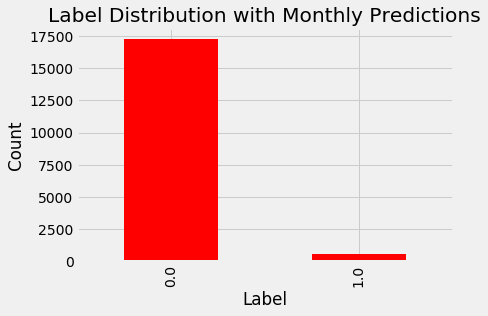

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

label_times['label'].value_counts().plot.bar(color = 'r');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Label Distribution with Monthly Predictions');

This is an imbalanced classification problem. There are far more instances of customers not churning than of customers churning. This is not necessarily an issue as long as we are smart about the choices of metrics we use for modeling. 

In [14]:
label_times = make_label_times(trans, 'SMS', 30)
label_times.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
43,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-10-15,0.0,NaN,NaT
44,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-11-01,0.0,NaN,NaT
45,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-11-15,0.0,NaN,NaT
46,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-12-01,0.0,NaN,NaT
47,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2016-12-15,0.0,NaN,NaT
48,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-01-01,0.0,NaN,NaT
49,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-01-15,0.0,NaN,NaT
50,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-02-01,0.0,NaN,NaT
51,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-02-15,0.0,NaN,NaT
52,zzm2UvJnzuTRkXaiaZHtbJwPG9jZQZkZxG0n4PYDTvw=,2017-03-01,0.0,NaN,NaT


In [15]:
label_times.shape

(49549, 5)

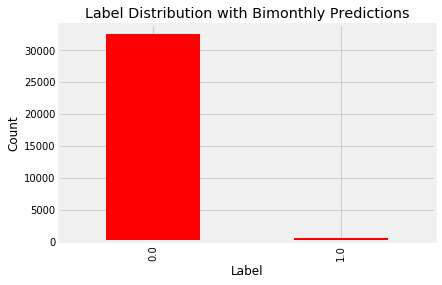

In [16]:
label_times['label'].value_counts().plot.bar(color = 'r');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Label Distribution with Bimonthly Predictions');

In [17]:
label_times['label'].isnull().sum()

16480

There are quite a few missing labels, which occur when there is no next transaction for the customer (we don't know if the last entry for the customer is a churn or not). We won't be able to use these examples when training a model although we can make predictions for them.

# Parallelizing Labeling

Now that we have a function that can make a label times table out of customer transactions, we need to label all of the customer transactions in our dataset. We already broke the data into 1000 partitions, so we can parallelize this operation using Spark with PySpark. The basic idea is to write a function that makes the label times for one partition, and then run this in parallel across all the partitions using either multiple cores on a single machine, or a cluster of machines. 

The function below takes in a partition number, reads the transactions data from S3, creates the label times table for both prediction problems, and writes the label times back to S3. We can run this function in parallel over multiple partitions at once since the customers are independent of one another. That is, the labels for one customer do not depend on the data for any other customer. 

In [18]:
def partition_to_labels(partition_number, label_types = ['MS', 'SMS'], churn_periods = [30, 14]):
    """Make labels for all customers in one partition
    Either for one month or twice a month
    
    Params
    --------
        partition (int): number of partition
        label_type (list of str): either 'MS' for monthly labels or
                                  'SMS' for bimonthly labels
        churn_periods (list of int): number of days required without a membership for a churn
    
    Returns
    --------
        None: saves the label dataframes with the appropriate name to the partition directory
    """
    partition_dir = BASE_DIR + 'p' + str(partition_number)
    
    # Read in data and filter anomalies
    trans = pd.read_csv(f'{partition_dir}/transactions.csv',
                        parse_dates=['transaction_date', 'membership_expire_date'], 
                        infer_datetime_format = True)
    trans = trans.loc[trans['membership_expire_date'] >= trans['transaction_date']]
    
    

    # Create both sets of lables
    for prediction_freq, churn_days in zip(label_types, churn_periods):
        
        cutoff_list = []
            
        # Make label times for all customers
        cutoff_list.append(make_label_times(trans, prediction_freq = prediction_freq, 
                                            churn_days = churn_days))
        # Turn into a dataframe
        cutoff_times = pd.concat(cutoff_list)
        cutoff_times = cutoff_times.drop_duplicates(subset = ['msno', 'cutoff_time'])
        
        # Encode in order to write to s3
        bytes_to_write = cutoff_times.to_csv(None, index = False).encode()

        # Write cutoff times to S3
        with fs.open(f'{partition_dir}/{prediction_freq}-{churn_days}_labels.csv', 'wb') as f:
            f.write(bytes_to_write)

In [19]:
partition_to_labels(1)

In [20]:
label_times = pd.read_csv('s3://customer-churn-spark/p1/MS-30_labels.csv')
label_times.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
26966,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2016-08-01,0.0,NaN,NaN
26967,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2016-09-01,0.0,NaN,NaN
26968,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2016-10-01,0.0,NaN,NaN
26969,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2016-11-01,0.0,NaN,NaN
26970,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2016-12-01,0.0,NaN,NaN
26971,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2017-01-01,0.0,NaN,NaN
26972,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2017-02-01,0.0,NaN,NaN
26973,ztr541XHzi0M0EPSrCSUEytFoqKIbZXNiJhszP8vuGw=,2017-03-01,0.0,NaN,NaN
26974,zxHN7E8uhYR9vlOKqRoFetJE03BESH+raGiZ8evjaec=,2017-02-01,0.0,NaN,NaN
26975,zxHN7E8uhYR9vlOKqRoFetJE03BESH+raGiZ8evjaec=,2017-03-01,0.0,NaN,NaN


In [21]:
label_times = pd.read_csv('s3://customer-churn-spark/p1/SMS-14_labels.csv')
label_times.head(10)

,msno,cutoff_time,label,days_to_churn,churn_date
0,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-01-01,0.0,NaN,NaN
1,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-01-15,0.0,NaN,NaN
2,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-02-01,0.0,NaN,NaN
3,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-02-15,0.0,NaN,NaN
4,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-03-01,0.0,NaN,NaN
5,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-03-15,0.0,NaN,NaN
6,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-04-01,0.0,NaN,NaN
7,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-04-15,0.0,NaN,NaN
8,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-05-01,0.0,NaN,NaN
9,+31Inxq3oTPJqYZz4kLCoBqxMpVuVeh3lZBS5gM/TJU=,2015-05-15,0.0,NaN,NaN


## Spark for Parallelization

The below code uses Spark to parallelize the label making. This particular implementation uses a single machine although the same idea can be extended to a cluster of machines.

In [22]:
import findspark
findspark.init('/usr/local/spark/')

import pyspark

conf = pyspark.SparkConf()

# Enable logging
conf.set('spark.eventLog.enabled', True);
conf.set('spark.eventLog.dir', '/data/churn/tmp/');

# Use all cores on a single machine
conf.set('spark.num.executors', 1)
conf.set('spark.executor.memory', '52g')
conf.set('spark.executor.cores', 15)

# Make sure to specify correct spark master ip
sc = pyspark.SparkContext(master = 'spark://ip-172-31-23-133.ec2.internal:7077',
                          appName = 'labeling', conf = conf)

sc

<SparkContext master=spark://ip-172-31-23-133.ec2.internal:7077 appName=labeling>

In [23]:
from timeit import default_timer as timer

# Parallelize making all labels in Spark
start = timer()
sc.parallelize(list(range(1000)), numSlices=1000).\
   map(partition_to_labels).collect()
sc.stop()
end = timer()

While Spark is running, you can navigate to localhost:4040 to see the details of the particular job, or to localhost:8080 to see the overview of the cluster. This is useful for diagnosing the state of a spark operation.

In [24]:
print(f'{round(end - start)} seconds elapsed.')

5976 seconds elapsed.


In [25]:
labels = pd.read_csv(f's3://customer-churn-spark/p980/MS-30_labels.csv')
labels.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
26209,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-06-01,NaN,NaN,NaN
26210,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-07-01,NaN,NaN,NaN
26211,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-08-01,NaN,NaN,NaN
26212,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-09-01,NaN,NaN,NaN
26213,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-10-01,NaN,NaN,NaN
26214,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-11-01,NaN,NaN,NaN
26215,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-12-01,NaN,NaN,NaN
26216,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-01-01,NaN,NaN,NaN
26217,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-02-01,NaN,NaN,NaN
26218,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-03-01,NaN,NaN,NaN


In [26]:
labels = pd.read_csv(f's3://customer-churn-spark/p980/SMS-14_labels.csv')
labels.tail(10)

,msno,cutoff_time,label,days_to_churn,churn_date
50022,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-10-15,NaN,NaN,NaN
50023,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-11-01,NaN,NaN,NaN
50024,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-11-15,NaN,NaN,NaN
50025,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-12-01,NaN,NaN,NaN
50026,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2016-12-15,NaN,NaN,NaN
50027,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-01-01,NaN,NaN,NaN
50028,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-01-15,NaN,NaN,NaN
50029,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-02-01,NaN,NaN,NaN
50030,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-02-15,NaN,NaN,NaN
50031,zuh7jGXSTQLrwHOgh9DDt2FmmsUXszvivNIF3RLSZck=,2017-03-01,NaN,NaN,NaN


# Conclusions

In this notebook, we implemented prediction engineering for the customer churn use case. After defining the business need, we translated it into a task that can be solved with machine learning and created a set of label times. The label times contain cutoff times for a specific prediction problem along with the associated label. The label times can now be used to make features for each label by filtering the data to before the cutoff time. This ensures that any features made are valid and will automatically be taken care of in Featuretools. 

The general procedure for making labels is:

1. Define the business requirement: predict customers who will churn during a specified period of time
2. Translate the business requirement into a machine learning problem: given historical customer data, build a model to predict which customers will churn depending on several parameters
3. Make labels along with cutoff times corresponding to the machine learning problem: develop functions that take in parameters so the same function can be used for multiple prediction problems.
4. Label all past historical data: parallelize operations by partitioning data into independent subsets

This approach can be extended to other problems. Although the exact syntax is specific to this use case, the overall approach is designed to be general purpose.

## Next Steps

With a complete set of label times, we can now make features for each label using the cutoff times to ensure our features are valid. However, instead of the painstaking and error-prone process of making features by hand, we can use automated feature engineering in [Featuretools](https://github.com/Featuretools/featuretools) to automated this process. Featuretools will build hundreds of relevant features using only a few lines of code and will automatically filter the data to ensure that all of our features are valid. The feature engineering pipeline is developed in the `Feature Engineering` notebook.